# GENERALISED COUNTRY-WISE POISSON REGRESSION

##  OVERVIEW

This notebook consist of the <b> Forecasting Module </b> of our Solution, This will consider the data from different sources, including the output of the <b> Markov Module </b> i.e the Stages at which a country is in a particular year. This notebook consist of following 6 Sections: 

<b> 1) Importing Packages  </b> <br> 
<b> 2) Loading Datasets and Preprocessing Steps  </b> <br>
<b> 3) ACF and PACF Plots for determine appropriate Lag  </b> <br> 
<b> 4) Data Visualization </b> <br>
<b> 5) Defining Utility Function for Data Modelling </b> <br>
<b> 6) Model Fitting and Results  </b> <br> 






## 1. IMPORTING PACKAGES

In [1]:
# Importing Packages

import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
import seaborn as sn
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_error

## 2. LOADING DATASETS AND PREPROCESSING STEPS 

In [12]:
# Reading the dataset

# Australia = pd.read_csv('Data/2nd May/Australia_Covid.csv')
# Austria = pd.read_csv('Data/2nd May/Austria_Covid.csv')
# China = pd.read_csv('Data/2nd May/China_Covid.csv')
# Iceland = pd.read_csv('Data/2nd May/Iceland_Covid.csv')
India = pd.read_csv('Data/12th May/India_data.csv')
# New_Zealand = pd.read_csv('Data/2nd May/New_Zealand_Covid.csv')
# S_korea = pd.read_csv('Data/2nd May/South_Korea_Covid.csv')
# Switzerland = pd.read_csv('Data/2nd May/Switzerland_Covid.csv')

In [13]:
India.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             250 non-null    object 
 1   location         250 non-null    object 
 2   new_cases        102 non-null    float64
 3   new_deaths       102 non-null    float64
 4   total_cases      102 non-null    float64
 5   total_deaths     102 non-null    float64
 6   Unnamed: 6       102 non-null    float64
 7   tests_per_thous  101 non-null    float64
 8   Susceptible      250 non-null    float64
 9   Infected         250 non-null    float64
 10  Recovered        250 non-null    float64
 11  I_x              250 non-null    float64
 12  Stages           250 non-null    int64  
dtypes: float64(10), int64(1), object(2)
memory usage: 25.5+ KB


In [3]:
def normalize_sig(df):
    df['norm_cases'] = df['new_cases']/np.std(df['new_cases'])
    df['norm_tests'] = df['total_tests']/np.std(df['total_tests'])
    df['norm_Lockdown'] = df['Lockdown']/np.std(df['Lockdown'])
    df['norm_days'] = df['days_completed']/np.std(df['days_completed'])
    df['norm_SD'] = df['Social_distancing']/np.std(df['Social_distancing'])
    df['norm_MR'] = df['Movement_restrictions']/np.std(df['Movement_restrictions'])
    return(df)

# Dataset Preprocessing before running the model
def dataset_preprocess(df):
    # Converting the datatype of dates to datetime
    dates = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
    # Adding dates to the dataframe
    df['Date'] = dates
    
    # Setting date as the index of the dataframe
    df = df.set_index('Date')
    return(df)

frames = [China, S_korea, Iceland, New_Zealand, Switzerland, Australia, Austria, India]
for i in frames:
    i = normalize_sig(i)
    i = dataset_preprocess(i)


def rolling_mean(country, p):
    y = country['norm_cases']
    x = y.rolling(p).mean()
    x = x.fillna(np.mean(y[0:(p-1)]))
    country['rol_new_cases'] = x
    return(country)

frames = [China, S_korea, Iceland, New_Zealand, Switzerland, Australia, Austria, India]
for i in frames:
    i = rolling_mean(i, 3)

# 3. PLOT ACF & PACF CURVES

In [4]:
from statsmodels.tsa.stattools import acf, pacf

In [5]:
def plot_ACF(df, p):
    df = df[df['days_completed']<p]
    lag_acf = acf(df['norm_cases'], nlags=20)
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

In [6]:
def plot_PACF(df,p):
    df = df[df['days_completed']<p]
    lag_pacf = pacf(df['norm_cases'], nlags=14, method='ols')
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

## Austria

/home/prerit/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


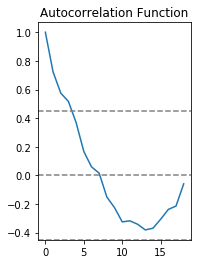

In [7]:
plot_ACF(Austria, 20)

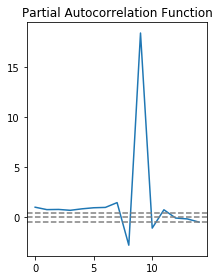

In [8]:
plot_PACF(Austria, 20)

## Australia

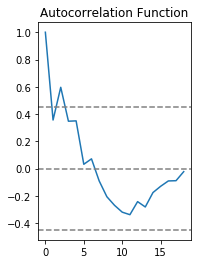

In [9]:
plot_ACF(Australia, 20)

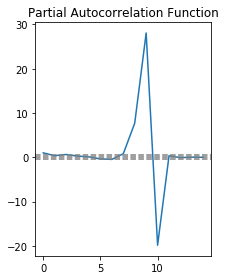

In [10]:
plot_PACF(Australia, 20)

## China

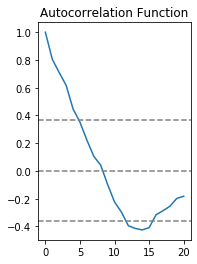

In [11]:
plot_ACF(China, 30)

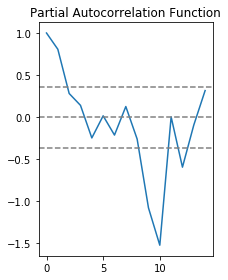

In [12]:
plot_PACF(China, 30)

## Iceland

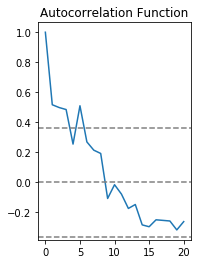

In [13]:
plot_ACF(Iceland,30)

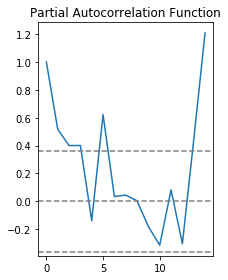

In [14]:
plot_PACF(Iceland, 30)

## India

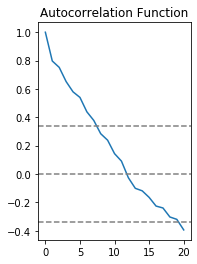

In [15]:
plot_ACF(India,50)

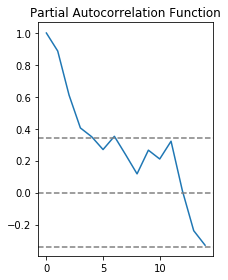

In [16]:
plot_PACF(India, 50)

## New Zealand

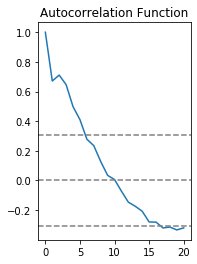

In [17]:
plot_ACF(New_Zealand, 50)

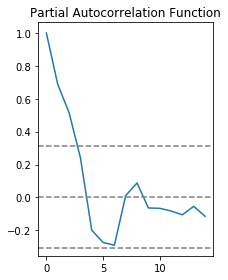

In [18]:
plot_PACF(New_Zealand, 50)

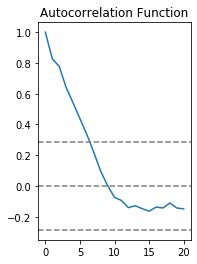

In [19]:
plot_ACF(S_korea, 50)

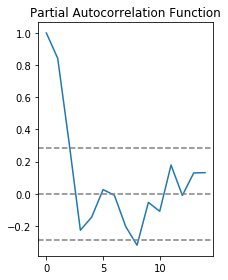

In [20]:
plot_PACF(S_korea, 50)

## Adding Lagged Values

In [21]:
def adding_lagged_values(df, lag):
    data = list(df['norm_cases'])
    lagged_data = []
    for i in range(lag):
        lagged_data.append(0)
    for i in range(lag, len(data)):
        lagged_data.append(data[i-lag])
    df['norm_lagged_cases'] = lagged_data
    df.reset_index()
    return(df)
# print(np.round(lagged_data, 2))

In [22]:
frames = [China, S_korea, Iceland, New_Zealand, Switzerland, Australia, Austria, India]
for i in frames:
    i = adding_lagged_values(i,14)

## 4. DATA VISUALIZATION

In [23]:
# Plotting the Confirmed Cases with Date
import matplotlib.pyplot as plt
import seaborn as sns

def plot_data(df, label):
    sns.set(rc = {'figure.figsize':(11,4)})
    df[label].plot(linewidth = 3, color = 'purple')

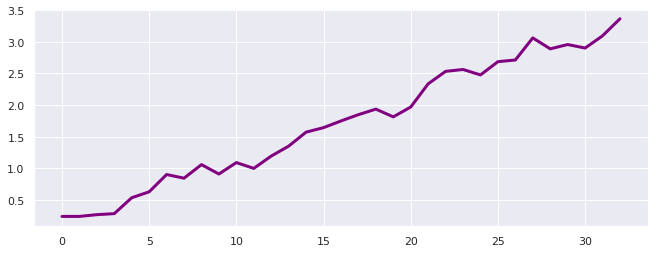

In [24]:
plot_data(India, 'rol_new_cases')

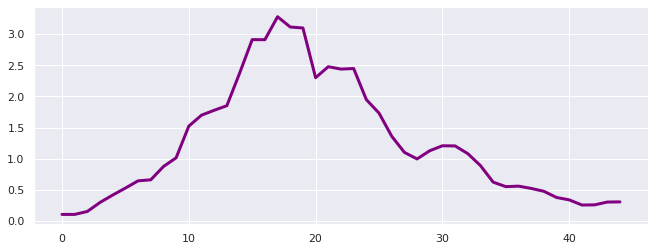

In [25]:
plot_data(Austria, 'rol_new_cases')

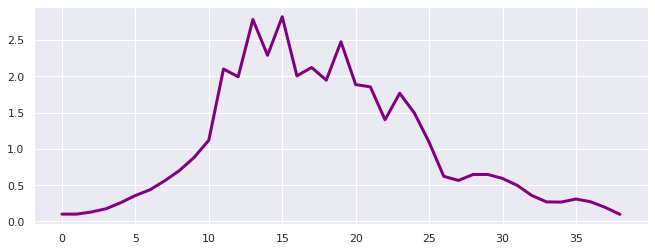

In [26]:
plot_data(Australia, 'rol_new_cases')

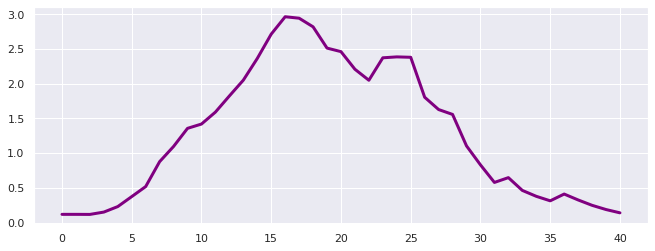

In [27]:
plot_data(China, 'rol_new_cases')

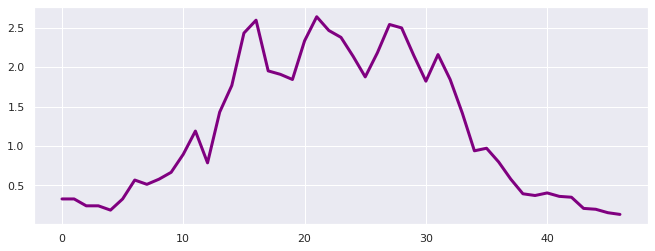

In [28]:
plot_data(Iceland, 'rol_new_cases')

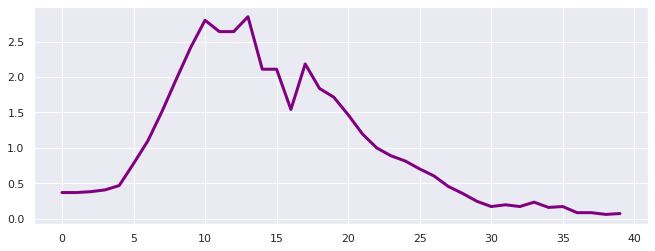

In [29]:
plot_data(New_Zealand, 'rol_new_cases')

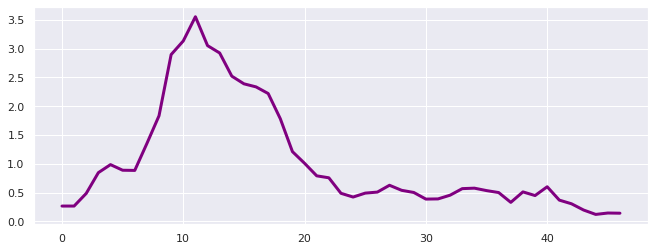

In [30]:
plot_data(S_korea, 'rol_new_cases')

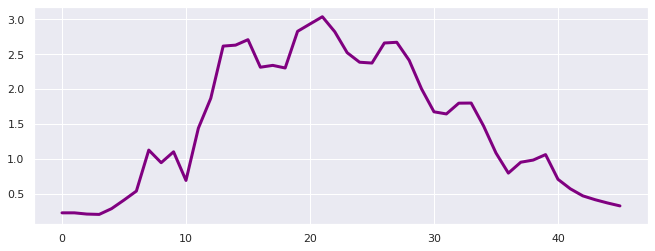

In [31]:
plot_data(Switzerland, 'rol_new_cases')

In [32]:
frames =   [China, S_korea, Iceland, New_Zealand, Switzerland, Australia, Austria]
data = pd.concat(frames)

## PLOTTING THE CORRELATION GRAPH

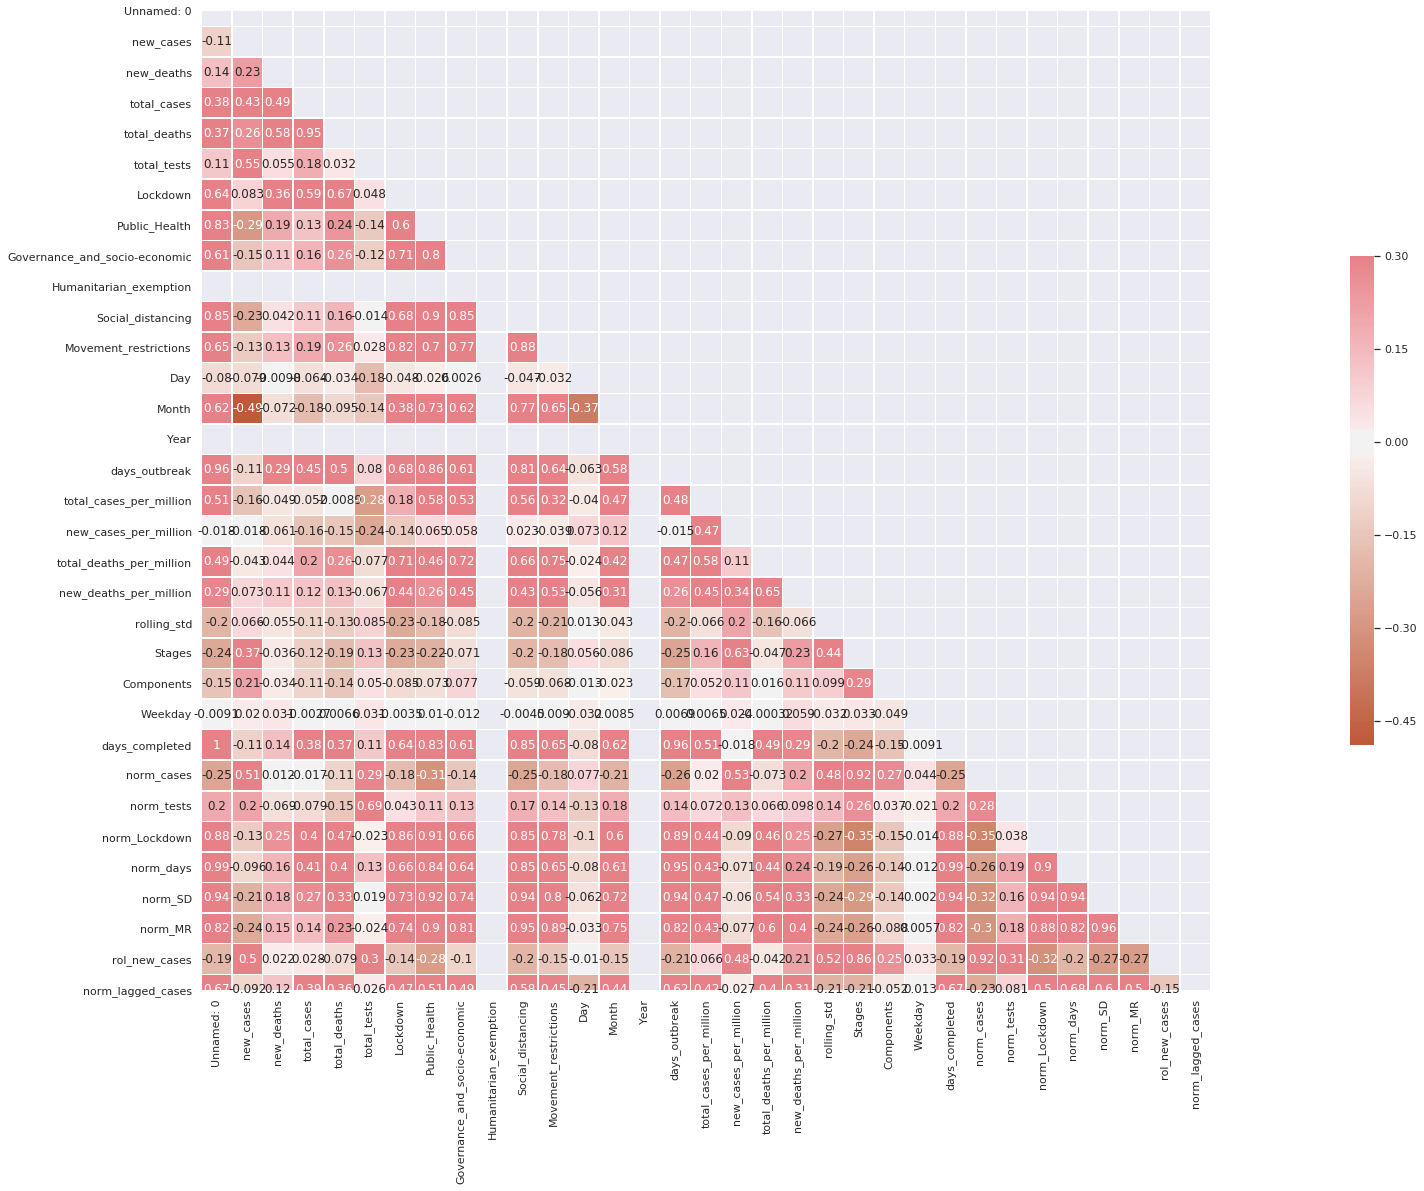

In [33]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(50, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(22, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot = True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 5. DEFINITION OF UTILITY FUNCTIONS FOR MODELLING DATA

In [34]:
expr = """ norm_cases ~ days_completed + Weekday + norm_Lockdown + Public_Health + Movement_restrictions + Social_distancing + norm_tests"""
expr1 = """ rol_new_cases ~norm_Lockdown + norm_tests + norm_lagged_cases + Stages + Components"""
expr2 = """ norm_cases ~ days_completed + Weekday + Lockdown + Movement_restrictions + Social_distancing + total_tests"""
expr3 = """ rol_new_cases ~ norm_days + norm_Lockdown + norm_MR + norm_SD + norm_tests + norm_lagged_cases + Stages + Components"""
expr4 = """ norm_cases ~norm_Lockdown + norm_tests + norm_lagged_cases + Stages + Components"""


def train_test_split(df,ratio, expr):
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_test = df[~mask]
    print('Training data set length='+str(len(df_train)))
    print('Testing data set length='+str(len(df_test)))
    
#     # Expression for the Model 
#     expr1 = """ cases cases ~ day + month + year   """#Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests"""~ day + month + year   """#Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests"""
#     expr2 = """cases ~ day + month + year + Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests"""
#     expr3 = """cases ~ day + month + year + Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests + popData2018"""

    ## Matrix Formation
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    return X_train, y_train, X_test, y_test

def train_model(y_train, X_train):
    model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    print(model.summary())
    return(model)

def predict(model, X_test):
    poisson_predictions = model.get_prediction(X_test)
    #.summary_frame() returns a pandas DataFrame
    predictions_summary_frame = poisson_predictions.summary_frame()
    print(predictions_summary_frame)
    return(predictions_summary_frame['mean'])
    
    
def plot_results(predictions_summary_frame,X_test, y_test, country, label):
    predicted_counts=predictions_summary_frame
    actual_counts = y_test[label]
    fig = plt.figure()
    fig.suptitle(str('Predicted Mean of Covid 19 Cofirmed Cases Count'))
    predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
    actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
    plt.legend(handles=[predicted, actual])
    plt.show()
    return(predicted_counts, actual_counts)
    
def plot_actual_vs_output(predicted_counts, actual_counts):
    plt.clf()
    fig = plt.figure()
    fig.suptitle('Scatter plot of Actual versus Predicted counts')
    plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
    plt.xlabel('Predicted counts')
    plt.ylabel('Actual counts')
    plt.show()

## 6. MODEL TRAINING AND RESULTS

In [35]:
data_update = data[data['days_completed'] < 30]

## STEP 1: TEST-TRAIN SPLIT

In [36]:

X_train, y_train, X_test, y_test = train_test_split(data_update,1, expr4) 
X_India, y_India, p, q = train_test_split(India,1, expr4)

Training data set length=203
Testing data set length=0
Training data set length=33
Testing data set length=0


## STEP 2: MODEL TRAINING AND SUMMARY

In [37]:
model = train_model(y_train, X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             norm_cases   No. Observations:                  174
Model:                            GLM   Df Residuals:                      168
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -197.72
Date:                Fri, 08 May 2020   Deviance:                       24.360
Time:                        21:57:14   Pearson chi2:                     22.6
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.4406      0.24

## STEP 3: PREDICTIONS

In [38]:
predictions_frame = (predict(model, X_India)*np.std(India['new_cases'])).rolling(3).mean()
predictions_frame = predictions_frame.fillna(0)

        mean   mean_se  mean_ci_lower  mean_ci_upper
0   0.451701  0.092024       0.302996       0.673386
1   0.480673  0.114304       0.301603       0.766064
2   0.506558  0.135982       0.299315       0.857291
3   0.513867  0.144059       0.296635       0.890183
4   1.035383  0.226722       0.674078       1.590347
5   0.548976  0.170316       0.298865       1.008398
6   1.072350  0.265194       0.660439       1.741167
7   1.082443  0.283495       0.647848       1.808577
8   1.101902  0.305388       0.640082       1.896925
9   0.563913  0.204148       0.277370       1.146474
10  1.137079  0.350613       0.621337       2.080915
11  1.161147  0.377400       0.614083       2.195572
12  1.173851  0.399705       0.602244       2.287985
13  2.266226  0.744880       1.189937       4.316011
14  1.184877  0.422263       0.589284       2.382439
15  1.213060  0.450024       0.586275       2.509940
16  2.357749  0.840708       1.172149       4.742555
17  2.413505  0.912559       1.150283       5.

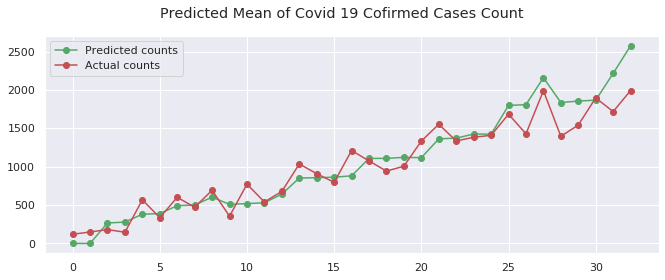

<function mean_squared_error at 0x7fc20f0092f0> 47120.11059498791
<function r2_score at 0x7fc20f009510> 0.8472970931687825
<function median_absolute_error at 0x7fc20f009400> 119.0
<function mean_absolute_error at 0x7fc20f009268> 163.1461709394181


In [39]:
predicted_counts, actual_counts = plot_results(predictions_frame,X_India, y_India*np.std(India['new_cases']), India, 'norm_cases')
scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
for i in scores: 
    print(i, i(actual_counts,predicted_counts))